# riverbed parameters

Thanks to this script we will carry out an inversion of the parameters of the riverbed, t
The inversion will focus on the four uncertain parameters and one boundary condition of this model, namely:

- the porosity $n$
- the intinsic permeability k,
- the thermal condictivity, 
- the heat capacity, 



# 1. Initiation Ginnette files

In [2]:
#!/usr/bin/env python

import os
import numpy as np
from pathlib import Path
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
import subprocess
import glob
import itertools
import seaborn as sns
import array
from scipy.interpolate import CubicSpline

libs_gfortran = ['gfortran']
# Définissez le répertoire où se trouvent les fichiers CSV
Obs_data = '../OBS_point/signy-amont/'

#-----------------------------------------------------------------
########### Setup of the model

#time step in s
dt=900
#duration of the simulation in days
nb_day=30
date_simul_bg=pd.to_datetime("2022-04-01 14:00:00")
# state
## 0 steady state
# 1 transient state (dynamic state)
state=1
coef=-1
ost=0
# size columnin meter
z_top=0.0
z_bottom=-0.4
#Observation positions x 0.50000
#Observation in meter
Obs1=z_top-0.1
Obs2=z_top-0.2
Obs3=z_top-0.3
Obs4=z_top-0.4

az=abs(z_top-z_bottom)
#discretisation : size cell in meter
dz=0.01

# number of facies in the column. If nb_zone=1 homognous porous media
nb_zone=2
#cote de la limitein meter, if you want more layer just add a new line
alt_thk=-0.25

# number of cell
nb_cell=az/dz

# porosity
REF_n=0.38 # \omega
#-----------------------------------------------------------------
# constant parameters
## intrinsic permeability [m2]  k=K*mu/(rho*g)
## K hydraulic conductivity [m.s-1]
## mu viscosity [Pa.s]
## rho density [kg.m-3]
## g gravity  9.81 [m2.s-1]
REF_k=3.33333333333333e-12
# solid grain density rho_s=val_r  [kg.m-3]
REF_r=1600


# Heat capacity is calculated  by the following relationship
#  c_pm= c_w r_w n  * sat+ c_s r (1-n) + c_a r_a n * (1-sat)
# 1.5 e+6 4e+6
#rho_m imposed : 1000
# high slow
# density
# c_s solid specific heat capacity
#val_c= c_s m2/s2/C I advice to let this value constant.
# There are no way to calibrate the both parameter rho and c in the same time.
#c_w=4185D+00	       m2/s2/C
#r_w=1000  kg/m3
# solid density r=val_r 
REF_c=2650
REF_l=8 #

if nb_zone==2:
    # zone 1
    # porosity
    REF_n=0.10 # \omega
    # intrinsic permeability [m2]  k=K*mu/(rho*g)
    REF_k=6e-30
    # Heat capacity
    REF_r=2500
    #lambda
    REF_l=7
    # zone 2
    # porosity
    REF_n2=0.05 # \omega
    # intrinsic permeability [m2]  k=K*mu/(rho*g)
    REF_k2=6e-15
    # solid grain density rho_s=val_r  [kg.m-3]
    REF_r2=1600
    REF_l2=3



# please compile ginette in the folder 1D_col
# path of the 1D_col directory
os.chdir('/home/ariviere/Programmes/ginette/application/sauer/GINETTE_SENSI/')
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

#-----------------------------------------------------------------
# Compile ginette
if os.path.isfile('ginette'):
    print ("ginette exist")
else:
    print ("ginette not exist")
    print("you must compile ginette in the current directory")
    print(" gfortran -o ginette ../../src/ginette_V2.f")
    subprocess.call(["gfortran","-o","ginette","../../../src/ginette_V2.f"])  #creat


print("la simulation commence à",date_simul_bg)
#-----------------------------------------------------------------
## write the setup of the moddeled domain
f_param_bck=open("E_parametre_backup.dat", "r")
f_param_new = open("E_parametre.dat", 'w')
setup_model=f_param_bck.read()
setup_model=setup_model.replace('[dt]','%06.0fD+00' % dt)
setup_model=setup_model.replace('[state]','%1i' % state)
setup_model=setup_model.replace('[nb_day]','%06.0f' % nb_day)
setup_model=setup_model.replace('[z_top]', '%7.3e' % z_top)
setup_model=setup_model.replace('[z_bottom]', '%7.2e' % z_bottom)
setup_model=setup_model.replace('[az]','%7.3e' % az)
setup_model=setup_model.replace('[dz]','%6.2e' % dz)
setup_model=setup_model.replace('[nb_cell]','%05.0f' % nb_cell)

cell1=abs(Obs1/dz)
cell2=abs(Obs2/dz)
cell3=abs(Obs3/dz)
cell4=abs(Obs4/dz)

setup_model=setup_model.replace('[cell1]','%05d' % cell1)
setup_model=setup_model.replace('[cell2]','%05d' % cell2)
setup_model=setup_model.replace('[cell3]','%05d' % cell3)
setup_model=setup_model.replace('[cell4]','%05d' % cell4)



f_param_new.write(setup_model)
f_param_bck.close()
f_param_new.close()






/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Current working directory: /home/ariviere/Programmes/ginette/application/sauer/GINETTE_SENSI
ginette exist
la simulation commence à 2022-04-01 14:00:00


# 2. Read observation data

In [3]:

# Obtenez la liste des fichiers dans le répertoire
fichiers = os.listdir(Obs_data)

info = None
all_data = None

for fichier in fichiers:
    if fichier.endswith('.csv'):
        if 'info' in fichier:
            info = pd.read_csv(os.path.join(Obs_data, fichier))
        elif 'dP' in fichier:
            all_data = pd.read_csv(os.path.join(Obs_data, fichier))
all_data['dates']=pd.to_datetime(all_data['dates'],format='%Y-%m-%d %H:%M:%S')
all_data=all_data[all_data['dates']>date_simul_bg]
# Réindexer le DataFrame
all_data.reset_index(drop=True, inplace=True)
all_data['deltaP']=all_data['deltaP']*coef+ost


date_begin= all_data['dates'].iloc[0]
date_end = pd.to_datetime(date_begin) + pd.to_timedelta(nb_day, unit='d')
print(date_begin,date_end)
# pas de temps
time_diff = all_data['dates'].diff().dropna()
indices_not_equal_900_sec = time_diff[time_diff != pd.Timedelta(seconds=900)].index

# pas de temps=900s
is_equal_900_sec = all(time_diff == pd.Timedelta(seconds=900))

if len(indices_not_equal_900_sec) == 0:
    print("Toutes les différences entre les lignes sont de 900 secondes.")
else:
    print("Les différences ne sont pas toutes de 900 secondes. Voici les indices concernés :")
    print(indices_not_equal_900_sec)
    # Afficher les lignes correspondantes dans le dataframe
    print(all_data.loc[indices_not_equal_900_sec])
all_data['dates']

2022-04-14 13:45:00 2022-05-14 13:45:00
Les différences ne sont pas toutes de 900 secondes. Voici les indices concernés :
Index([9303, 14843, 22614], dtype='int64')
                    dates    VMolo    deltaP  TempMolo   Temp1   Temp2  \
9303  2022-07-20 14:06:21  1.27306  0.025912    23.901  23.970  23.546   
14843 2022-09-16 11:20:03  1.20228 -0.028065    16.726  16.769  16.790   
22614 2022-12-06 13:00:00  2.49996  1.281547     5.622   5.647   6.199   

        Temp3   Temp4  
9303   22.905  22.702  
14843  16.732  16.755  
22614   6.908   7.503  


0       2022-04-14 13:45:00
1       2022-04-14 14:00:00
2       2022-04-14 14:15:00
3       2022-04-14 14:30:00
4       2022-04-14 14:45:00
                ...        
40845   2023-06-14 10:45:00
40846   2023-06-14 11:00:00
40847   2023-06-14 11:15:00
40848   2023-06-14 11:30:00
40849   2023-06-14 11:45:00
Name: dates, Length: 40850, dtype: datetime64[ns]

In [4]:
# Trouver les horodatages qui ne commencent pas à des intervalles de 15 minutes et ajuster uniquement ceux-là
#mask = all_data['dates'].dt.minute % 15 != 0
#all_data.loc[mask, 'timestamps'] = all_data.loc[mask, 'dates'] - pd.to_timedelta(all_data.loc[mask, 'dates'].dt.minute % 15, unit='m')
# Réinitialiser les secondes à zéro pour tous les horodatages
all_data['dates'] = all_data['dates'].dt.floor('min')
all_data['dates'] = all_data['dates'].dt.floor('15T')


In [5]:

all_data['timestamps']=all_data['dates']

# Créez un nouvel index avec des dates toutes les 15 minutes
new_index = pd.date_range(start=all_data['timestamps'].min(), end=all_data['timestamps'].max(), freq='15T')

# Réindexez le DataFrame pour inclure ces nouvelles dates
all_data = all_data.set_index('timestamps').reindex(new_index)
# Sélection des colonnes pour l'interpolation
columns_to_interpolate = ['deltaP', 'TempMolo', 'Temp1', 'Temp2', 'Temp3', 'Temp4']

# Appliquez l'interpolation uniquement sur la colonne 'valeur'
all_data[columns_to_interpolate] = all_data[columns_to_interpolate].interpolate(method='time')




In [6]:

# Vérification des écarts temporels après l'interpolation
time_diff = all_data['dates'].diff().dropna()
indices_not_equal_900_sec = time_diff[time_diff != pd.Timedelta(seconds=900)].index

if len(indices_not_equal_900_sec) == 0:
    print("Toutes les différences entre les lignes sont de 900 secondes.")
else:
    print("Les différences ne sont pas toutes de 900 secondes. Voici les indices concernés :")
    print(indices_not_equal_900_sec)
    # Afficher les lignes correspondantes dans le dataframe
    print(all_data.loc[indices_not_equal_900_sec])

Toutes les différences entre les lignes sont de 900 secondes.


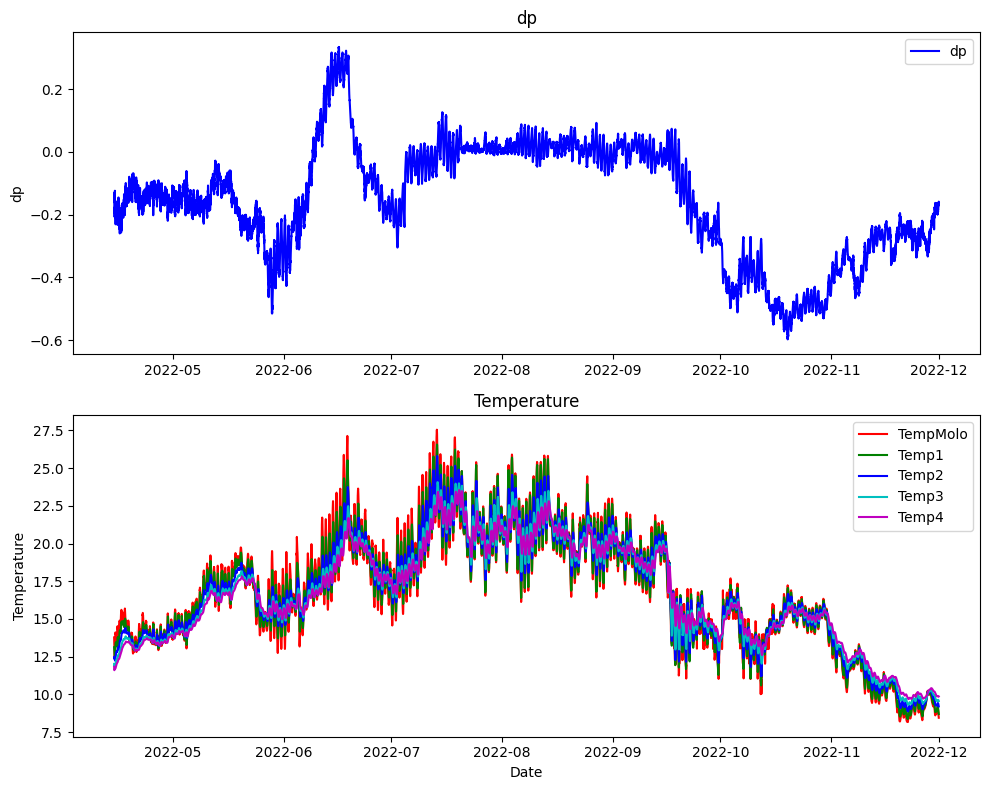

In [7]:
all_data= all_data[ (all_data['dates'] < '2022-12-01')]
# Creating subplots for 'dp' and 'temp' graphs vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotting 'dp'
ax1.plot(all_data['dates'], all_data['deltaP'], 'b-', label='dp')
ax1.set_ylabel('dp')
ax1.set_title('dp')
ax1.legend()

# Plotting 'Temps'
temp_columns = ['TempMolo', 'Temp1', 'Temp2', 'Temp3', 'Temp4']
colors = ['r', 'g', 'b', 'c', 'm']
for i, col in enumerate(temp_columns):
    ax2.plot(all_data['dates'], all_data[col], color=colors[i], label=col)

ax2.set_xlabel('Date')
ax2.set_ylabel('Temperature')
ax2.set_title('Temperature')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

# Zoom temperature



In [8]:
filtered_data = all_data[(all_data['dates'] > '2022-04-01') & (all_data['dates'] < '2022-05-16')]


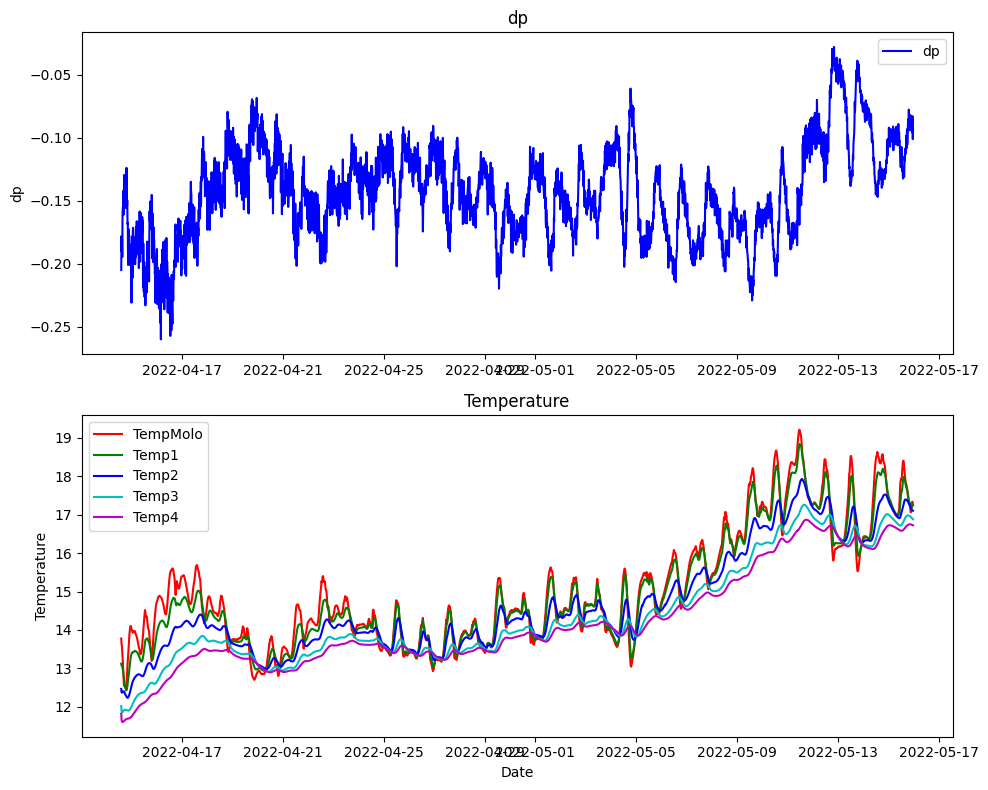

In [9]:
# Creating subplots for 'dp' and 'temp' graphs vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotting 'dp'
ax1.plot(filtered_data['dates'],filtered_data['deltaP'], 'b-', label='dp')
ax1.set_ylabel('dp')
ax1.set_title('dp')
ax1.legend()

# Plotting 'Temps'
temp_columns = ['TempMolo', 'Temp1', 'Temp2', 'Temp3', 'Temp4']
colors = ['r', 'g', 'b', 'c', 'm']
for i, col in enumerate(temp_columns):
    ax2.plot(filtered_data['dates'], filtered_data[col], color=colors[i], label=col)

ax2.set_xlabel('Date')
ax2.set_ylabel('Temperature')
ax2.set_title('Temperature')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

## 2. Reference simulation 

In [10]:
########### Zone of parameters
f_coor=open("E_coordonnee.dat", "w")
f_zone=open("E_zone.dat", 'w')
f_paramZ_bck=open("E_zone_parameter_backup.dat", "r")
f_paramZ_new = open("E_zone_parameter.dat", 'w')

param_zone=f_paramZ_bck.read()
coord=pd.DataFrame()    

# replace the parameter values
param_zone=param_zone.replace('[k1]','%8.2e' % REF_k)
param_zone=param_zone.replace('[n1]','%6.2f' % REF_n)
param_zone=param_zone.replace('[l1]','%6.2f' % REF_l)
param_zone=param_zone.replace('[r1]','%6.2f' % REF_r)

if nb_zone ==2 :
    f_param_bck.close()
    f_paramZ_bck=open("E_zone_parameter_backup_2zones.dat","r")
    param_zone=f_paramZ_bck.read()
    param_zone=param_zone.replace('[k1]','%8.2e' % REF_k)
    param_zone=param_zone.replace('[n1]','%6.2f' % REF_n)
    param_zone=param_zone.replace('[l1]','%6.2f' % REF_l)
    param_zone=param_zone.replace('[r1]','%6.2f' % REF_r)
    param_zone=param_zone.replace('[k2]','%8.2e' % REF_k2)
    param_zone=param_zone.replace('[n2]','%6.2f' % REF_n2)
    param_zone=param_zone.replace('[l2]','%6.2f' % REF_l2)
    param_zone=param_zone.replace('[r2]','%6.2f' % REF_r2)
                      
    
# Coodrinate  
zvalues =  np.sort(np.arange(z_bottom+dz/2,dz/2,dz ))

xvalues = np.array([0.5])
zz, xx = np.meshgrid(zvalues, xvalues)
NT = np.product(zz.shape)
data = {
    "x": np.reshape(xx,NT),
    "z": np.reshape(zz,NT)}
coord = pd.DataFrame(data=data)
coord['id']=coord.index.values.astype(int)
coord['id']=coord['id']+1
cols = coord.columns.tolist()
cols = cols[-1:] + cols[:-1]
coord = coord[cols] 
coord.to_csv(f_coor, index = False, sep=' ', header=False)
#zone parameter by cell ((homogenous domain = 1 zone))
coord['zone'] =1


#Pour plusieurs zones modification AR
if nb_zone >= 2:
        coord['zone'] = np.where(coord['z'] >= alt_thk, 2,coord['zone'])
#Write new ginette files
f_paramZ_new.write(param_zone)

coord.zone.to_csv(f_zone, index = False, header=False)

# close files    
f_zone.close()
f_coor.close()
f_paramZ_new.close()
f_paramZ_bck.close()






# Inital conditions
f_temp_IC=open("E_temperature_initiale.dat","w")
initial_temps = all_data.iloc[0][['Temp1', 'Temp2', 'Temp3', 'Temp4']]
z_temps = np.array([-0.1, -0.2, -0.3, -0.4])
initial = pd.DataFrame({'z': z_temps, 'T': initial_temps})
initial['z'] = initial['z'].astype(float)
initial['T'] = initial['T'].astype(float)


# Define the range of depths for interpolation
dz_bot=z_bottom+dz/2
dz_top=z_top+0.001
z_values = np.arange(dz_bot, 0.001, dz)  # Depth range from -0.4 to 0.005

# Perform linear interpolation
Temp_init = np.interp(z_values, initial['z'][::-1], initial['T'][::-1])  # Reversed to align with depths

# Creating a DataFrame for the interpolated data
interpolated_temp = {
    'z': z_values,
    'T': Temp_init
}

interpolated_temp = pd.DataFrame(interpolated_temp)
interpolated_temp_sorted = interpolated_temp.sort_values(by='z', ascending=False)

interpolated_temp_sorted['T'].to_csv(f_temp_IC, index = False, sep='\n', header=False)

# To apply dp to the column, we need to convert it to a pressure value
f_chg_IC=open("E_charge_initiale.dat","w")
initial_pres = all_data.iloc[0][['deltaP']]*-1
initial_chg = pd.DataFrame({'z': z_bottom, 'chg': [0]})
new_row = pd.DataFrame({'z': z_top, 'chg':initial_pres})
initial_chg = pd.concat([initial_chg, new_row], ignore_index=True)
initial_chg['z'] = initial_chg['z'].astype(float)
initial_chg['chg'] = initial_chg['chg'].astype(float)
# Define the range of depths for interpolation
dz_bot=z_bottom+dz/2
dz_top=z_top+0.001
z_values = np.arange(dz_bot, 0.001, dz)  # Depth range from -0.4 to 0.005


# Perform linear interpolation
charge_init = np.interp(z_values, initial_chg['z'][:], initial_chg['chg'][:])  # Reversed to align with depths

# Creating a DataFrame for the interpolated data
interpolated_chg = {
    'z': z_values,
    'chg': charge_init
}
interpolated_chg = pd.DataFrame(interpolated_chg)
interpolated_chg_sorted = interpolated_chg.sort_values(by='z', ascending=False)



interpolated_chg_sorted['chg'].to_csv(f_chg_IC, index = False, sep='\n', header=False)

f_chg_IC.close()
f_temp_IC.close()

In [11]:
# Boundary conditions
all_data['bot']=0
all_data['top']=all_data['deltaP']*-1
all_data[['top','bot']].to_csv('E_charge_t.dat', sep=' ', index=False, header=False)
all_data[['Temp1', 'Temp4']].to_csv('E_temp_t.dat', sep=' ', index=False, header=False)

In [12]:
# run ginette
subprocess.call(["./ginette"])

0

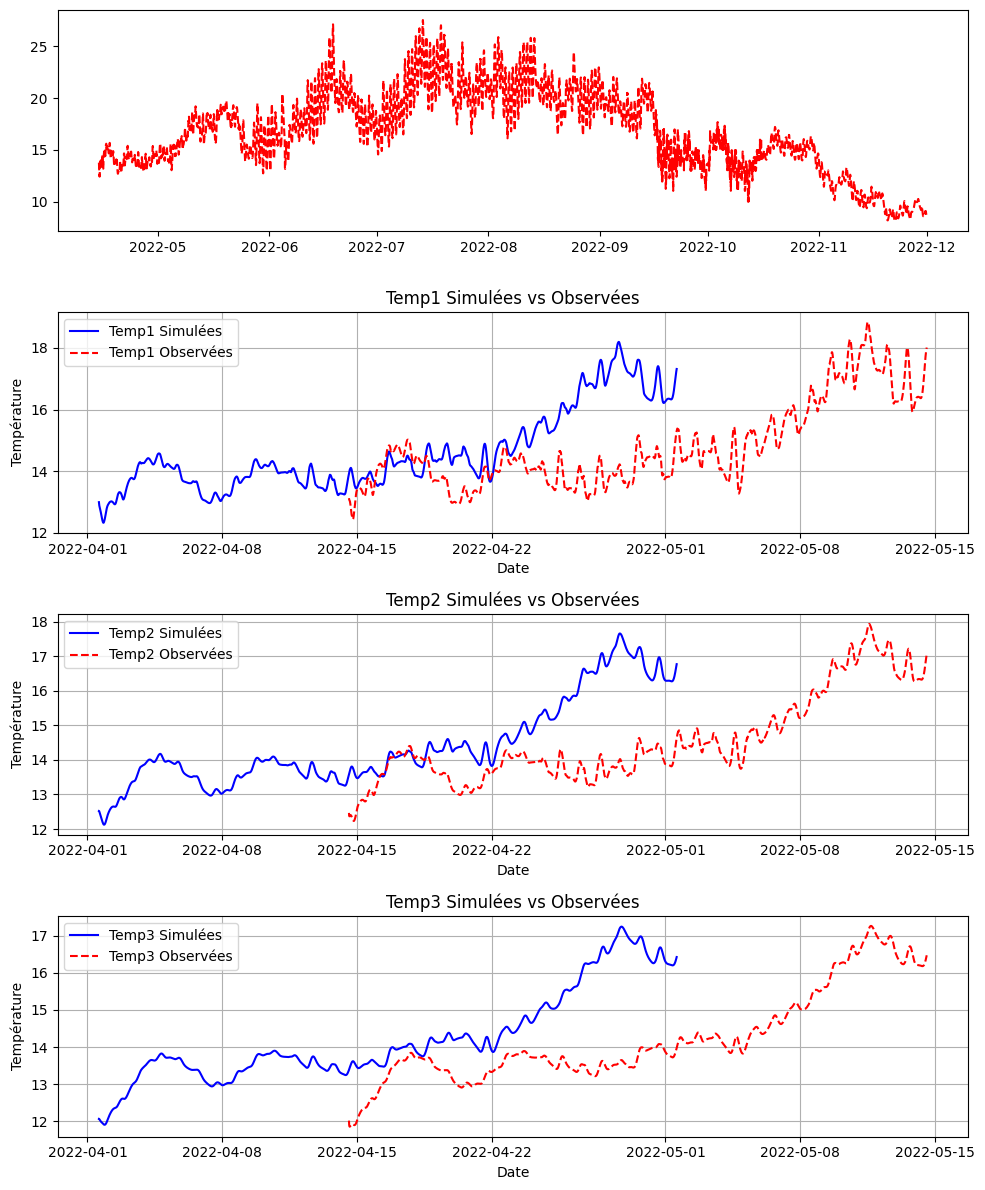

In [13]:
# Colonnes pour les températures
column_names = ['Temp_1', 'Temp_2', 'Temp_3']

# Liste pour stocker les DataFrames
all_dfs = []
# Lire et stocker les DataFrames
for i in range(1,4 ):
    file_path = f'Sim_temperature_maille{i}_t.dat'
    df = pd.read_csv(file_path, sep='\s+', header=None, names=['Time', f'Temp{i}'])
    all_dfs.append(df)

# Fusionner les DataFrames sur la colonne 'Time'
sim_temp = all_dfs[0]  # Utiliser le premier DataFrame comme base

for df in all_dfs[1:]:
    sim_temp = pd.merge(sim_temp, df, on='Time', how='outer')

# Trier les colonnes par ordre numérique
sim_temp = sim_temp.reindex(sorted(sim_temp.columns), axis=1)
sim_temp['dates'] = pd.to_datetime(date_simul_bg) + pd.to_timedelta(sim_temp['Time'], unit='s')

obs_temp = all_data[all_data['dates'] < date_end]
# Tracer les températures simulées et observées pour chaque température
fig, axs = plt.subplots(4, 1, figsize=(10, 12))
axs[0].plot(all_data['dates'], all_data['TempMolo'], label='TempMolo Observées', linestyle='--', color='red')
# Tracer les températures simulées (sim_temp)
for i in range(1, 4):
    axs[i].plot(sim_temp['dates'], sim_temp[f'Temp{i}'], label=f'Temp{i} Simulées', linestyle='-', color='blue')

# Tracer les températures observées (sim_obs)
  
for i in range(1, 4):
    axs[i].plot(obs_temp['dates'], obs_temp[f'Temp{i}'], label=f'Temp{i} Observées', linestyle='--', color='red')

    # Configurations supplémentaires pour chaque subplot
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Température')
    axs[i].set_title(f'Temp{i} Simulées vs Observées')
    axs[i].legend()
    axs[i].grid(True)

# Afficher les subplots
plt.tight_layout()
plt.show()


In [14]:
# Fusionner les DataFrames en fonction des dates communes
merged_data = pd.merge(obs_temp, sim_temp, on='dates', how='inner')
merged_data = merged_data.rename(columns={
    'Temp1_x': 'Temp1_obs',
    'Temp2_x': 'Temp2_obs',
    'Temp3_x': 'Temp3_obs',
    'Temp1_y': 'Temp1_sim',
    'Temp2_y': 'Temp2_sim',
    'Temp3_y': 'Temp3_sim'
})

merged_data

,dates,VMolo,deltaP,TempMolo,Temp1_obs,Temp2_obs,Temp3_obs,Temp4,bot,top,Temp1_sim,Temp2_sim,Temp3_sim,Time
0,2022-04-14 13:45:00,1.01682,-0.205057,13.778,13.124,12.467,12.022,11.821,0,0.205057,13.923512,13.580306,13.385704,1122300.0
1,2022-04-14 14:00:00,1.04383,-0.178053,13.660,13.081,12.388,11.910,11.686,0,0.178053,13.959796,13.604215,13.400716,1123200.0
2,2022-04-14 14:15:00,1.03117,-0.190440,13.595,13.064,12.370,11.874,11.637,0,0.190440,13.993595,13.628402,13.416150,1124100.0
3,2022-04-14 14:30:00,1.04120,-0.180383,13.538,13.052,12.370,11.862,11.616,0,0.180383,14.023115,13.652381,13.431973,1125000.0
4,2022-04-14 14:45:00,1.02647,-0.194658,13.401,13.038,12.378,11.859,11.605,0,0.194658,14.046837,13.675563,13.448130,1125900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629,2022-05-01 13:00:00,1.03429,-0.191528,15.457,15.152,14.469,13.894,13.745,0,0.191528,17.140409,16.634703,16.340253,2588400.0
1630,2022-05-01 13:15:00,1.04063,-0.185348,15.500,15.197,14.503,13.915,13.756,0,0.185348,17.189478,16.668398,16.359659,2589300.0
1631,2022-05-01 13:30:00,1.02461,-0.201289,15.536,15.243,14.557,13.934,13.765,0,0.201289,17.235496,16.702042,16.379967,2590200.0
1632,2022-05-01 13:45:00,1.03735,-0.188726,15.558,15.279,14.598,13.957,13.775,0,0.188726,17.277932,16.735306,16.400952,2591100.0


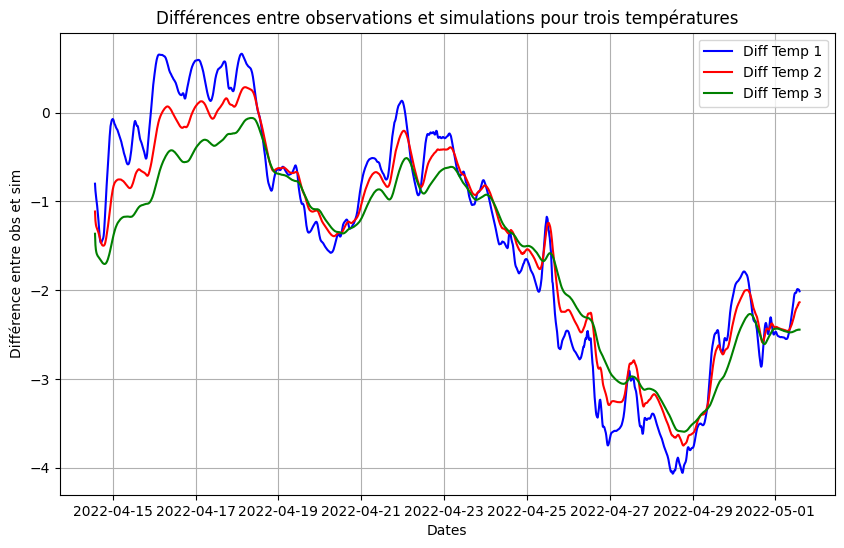

In [15]:
# Calculer les différences entre les températures simulées et observées
merged_data['Diff_Temp1'] = merged_data['Temp1_obs'] - merged_data['Temp1_sim']
merged_data['Diff_Temp2'] = merged_data['Temp2_obs'] - merged_data['Temp2_sim']
merged_data['Diff_Temp3'] = merged_data['Temp3_obs'] - merged_data['Temp3_sim']



# Création du graphique
plt.figure(figsize=(10, 6))

plt.plot(merged_data['dates'], merged_data['Diff_Temp1'], label='Diff Temp 1', color='blue')
plt.plot(merged_data['dates'], merged_data['Diff_Temp2'], label='Diff Temp 2', color='red')
plt.plot(merged_data['dates'], merged_data['Diff_Temp3'], label='Diff Temp 3', color='green')

plt.xlabel('Dates')
plt.ylabel('Différence entre obs et sim')
plt.title('Différences entre observations et simulations pour trois températures')
plt.legend()
plt.grid(True)

plt.show()

In [16]:
import numpy as np

def calculate_metrics(data):
    metrics = {}

    for i in range(1, 4):
        sensor = f'Temp{i}'
        diff_sensor = f'Diff_Temp{i}'

        diff = data[diff_sensor]
        
        rmse = np.sqrt(np.mean(diff**2))  # RMSE
        mae = np.mean(np.abs(diff))  # MAE
        bias = 100 * np.sum(diff) / np.sum(np.abs(data[f'{sensor}_obs']))  # PBias

        std_obs = data[f'{sensor}_obs'].std()
        std_sim = data[f'{sensor}_sim'].std()
        mean_obs = data[f'{sensor}_obs'].mean()
        mean_sim = data[f'{sensor}_sim'].mean()

        kge = 1 - np.sqrt((np.square(std_sim/std_obs - 1)) +
                            (np.square(mean_sim/mean_obs - 1)) +
                            (np.square(rmse/std_obs - 1)))

        metrics[sensor] = {'RMSE': rmse, 'MAE': mae, 'PBias': bias, 'KGE': kge}

    return metrics

# Appel de la fonction pour calculer les métriques pour chaque capteur
metrics_dict = calculate_metrics(merged_data)

# Affichage des résultats
for sensor, metrics in metrics_dict.items():
    print(f"Métriques pour {sensor}:")
    print(f"RMSE: {metrics['RMSE']}")
    print(f"MAE: {metrics['MAE']}")
    print(f"PBias: {metrics['PBias']}")
    print(f"KGE: {metrics['KGE']}")
    print()


Métriques pour Temp1:
RMSE: 1.931558014599174
MAE: 1.5276398406011344
PBias: -10.030600325145743
KGE: -1.9016830419920954

Métriques pour Temp2:
RMSE: 1.8226306446312892
MAE: 1.4499154913802048
PBias: -10.398600960948517
KGE: -2.323243314343743

Métriques pour Temp3:
RMSE: 1.8507573823967656
MAE: 1.5504216136874394
PBias: -11.55552494974039
KGE: -2.452393092461147



# Flux eau

In [1]:
flux_eau=pd.read_csv('Sim_velocity_profil_t.dat',sep='\s+',header=None)
flux_eau = flux_eau.rename(columns={0: 'Time', 1: 'z', 2: 'v'})
flux_eau

NameError: name 'pd' is not defined

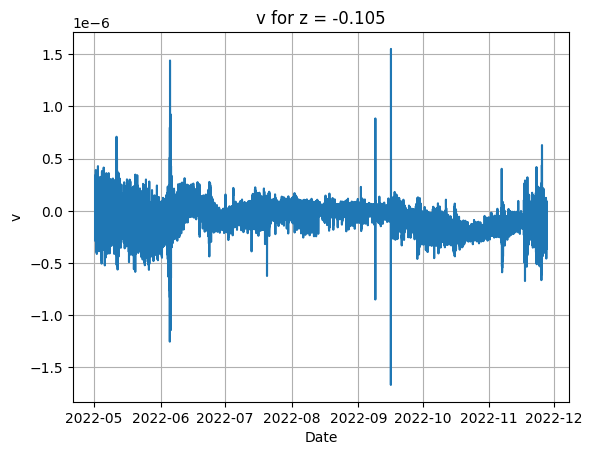

In [ ]:
flux_eau['dates'] = pd.to_datetime(date_simul_bg) + pd.to_timedelta(flux_eau['Time'], unit='s')

selected_data = flux_eau[flux_eau['z'] == -0.105]
plt.plot(selected_data['dates'], selected_data['v'])
plt.xlabel('Date')
plt.ylabel('v')
plt.title('v for z = -0.105')
plt.grid(True)
plt.show()
